# Programming assignment 5: spotting cars using convolutional neural networks

* Neha Devi Shakya
* Sarvesh Meenowa
* Khushi Chitra Uday

In this assignment, we will see a few different approaches to building image classifiers using convolutional neural networks.

We have a small image dataset and our task is to train a CNN that can find images that contain cars. CNNs are data-hungry in general and we won't get a fantastic accuracy using this dataset, so as an alternative we'll explore the opportunity to "piggyback" on a pre-trained CNN model for another image classification task.

Purposes of this assignment:

* practicing the use of the Keras library for neural network development;
* getting some practical experience of working with image data and CNNs;
* investigating overfitting in CNNs;
* learning how to improve your CNN using data augmentation and transfer learning tricks.

Work in a group up of two or three people. You should submit a single Jupyter notebook including your code and comments as Markdown boxes.

Before submitting, please make sure that:

* the names of all members of the group are listed at the beginning of the notebook;
* all intermediate steps, results, and your conclusions are described carefully;
* the code can be executed **in one go without crashing or errors**. If you use a notebook, please select Restart & Run All in the Kernel menu before you submit;

Submit the files at the submission page in Canvas.

## Preliminaries

* Repeat the lectures (or at least the notebooks) about neural network basics and convolutional neural networks.
* Make sure that Keras is installed. You can install by entering `conda install tensorflow` if using Anaconda. (The most recent version of Keras is bundled with the TensorFlow library.)
* If you are installing via pip/pip3 rather than Anaconda, you will need to install `h5py` as well, if you'd like to be able to save your trained models.
* Install the image processing library Pillow, which is needed by the Keras functions that load the images. (`conda install pillow` or `p
ip3 install Pillow`)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
!pip install h5py
!pip install pillow

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Dense, Dropout, Embedding, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits import mplot3d

## Introduction: Loading images from a directory
In this section, we'll see how we can a set of images stored in a directory. Your work here does not need to be included in the report.

First download the package containing the images [here](https://chalmers.instructure.com/files/2151328/download?download_frd=1) and unpack it. These images have been extracted from a dataset included in the [PASCAL Visual Object Classes Challenge 2010] (http://host.robots.ox.ac.uk/pascal/VOC/voc2010/) (VOC2010).

The structure of the directory is

* a5_images
    * train
        * car [800 images]
        * other [800 images
    * validation
        * car [288 images]
        * other [288 images]

so as you can see, the images have already been split into a training and a validation set, and each subset contains a separate directory for each of the two classes (`car` and `other`). The class `other` contains images of various objects.

Keras includes a function `load_img` to load a single image, but we'll use a more practical approa`
ch for this assignment.

We first declare an `ImageDataGenerator`. This is an object that defines how images should be converted into NumPy data. In our case, we add a parameter `rescale`; this means that the color values range from 0 to 1 instead of 0 to 255. (This transformation is similar to a scaler in scikit-learn and has a similar purpose.)

In [ ]:
data_gen = ImageDataGenerator(rescale = 1.0/255)

Now, let's read the images in the training set. By calling `flow_from_director`, we apply the `ImageDataGenerator` to transform the images stored in a directory. This will return a generator object that loads images, transforms them, and returns them in batches of a given size.

The parameters used here are:

* the location of the training images;
* `target_size` is for the size of the images: in our case, we'll resize them so that they are all 64x64 pixels;
* `batch_size` refers to the batch size we'll use when training;
* `class_mode='binary'` means that we'll treat the learning problem as a binary classification problem;
* `classes` is provided to make sure that `other` is coded as 0 and `car` as 1;
* `seed` is an arbitrary integer that initializes the random number generator for reproducibility;
* `shuffle` because we'd like the images to appear in a random order when training.

If you have a severe performance problem, you can resize the images to some size smaller than 64x64. This is likely to give you a slightly lower classification accuracy. (Conversely, if you have a high-end machine, you may consider increasing the image size.

In [ ]:
imgdir = '/content/drive/Shareddrives/Applied Machine Learning/PA5/a5_images' # or wherever you put them...
img_size = 64
batch_size = 32

train_generator = data_gen.flow_from_directory(
        imgdir + '/train',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        classes=['other', 'car'],
        seed=12345,
        shuffle=True)

Found 1600 images belonging to 2 classes.


We'll take a look at a few images. We first read one batch from the generator. This will return a part of the training data: some images, and the corresponding labels (0 for `other`, 1 for `car`).



In [ ]:
Xbatch, Ybatch = train_generator.next()

What is the form of the images in the batch? We take a look at the NumPy object that was returned. It is a four-dimensional NumPy array (formally, a four-dimensional tensor).


The dimensions are

* 32, because there are 32 images in the batch
* 64, for the height of each image
* 64, for the width of each image
* 3, because for each pixel we store the red, green, and blue value (a value between 0 and 1)

In [ ]:
Xbatch.shape

(32, 64, 64, 3)

We'll take a look at the first instance. First, let's check whether this is a car or not. In my case, the label is 0 for the first instance, meaning that this is not a car. This doesn't have to be the case for you, because the images appear in a random order (`shuffle=True`).

In [ ]:
Ybatch[4]

1.0

Draw the image using `plt.imshow`. (Assuming you have imported `matplotlib.pyplot` as `plt`.) As usual when plotting, you'll need to call `plt.show()` or `plt.savefig()`, or use an interactive notebook, to see something.

Hopefully, you can confirm from the image whether this is a car or not (and this should agree with `Ybatch[0]`). It might be a bit hard to see, because we resized the image to 64x64.

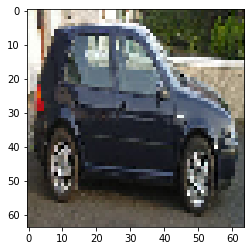

In [ ]:
plt.imshow(Xbatch[4]);

## Part 1: Training a convolutional neural network
Write a function `make_convnet` that builds a convolutional neural network.

The input shape should be `(img_size, img_size, 3)`, where `img_size` is the image size we defined above (such as 64), and 3 is for the red, green, and blue "channels" of the image. If you make use of the code we saw during the lecture, please note that this is a binary classification problem, so it's probably good to change the output layer and use another loss function.

Also remember to select a suitable optimizer.

Before you can train the CNN, you need to make a second data generator for the generation of validation images. You should again use `data_gen.flow_from_directory`, but use the validation directory instead of the training directory.

Now we have everything that we need to train the CNN. Call `fit` to train the model.

In most cases, training will be fairly time-consuming. The exact amount needed will depend on your machine, how you constructed your CNN, and how many epochs you let it train. Typically, training will take a few minutes.

Optionally, call `your_cnn.save_weights(some_file_name)` after training. This will save your weights to a file; you can recover them later using `your_cnn.load_weights(the_same_file_name)`, so that you can run your CNN several times without having to re-train every time.

**Hint**: Depending on how you build your CNN, you will see different accuracies. The dataset is balanced, so a majority-class dummy baseline would have an accuracy of 0.5. Let's hope you can get a better result than that. The validation set is a bit small because we don't have that much data, so you will probably see some fluctuation in the accuracy values.

Plot the training and validation loss for each epoch. Also plot the training and validation accuracies in another plot.

If you need to run the model on a dataset that you access via a generator, you can use `evaluate`. The loss function and the accuracy will be computed. (As you can see, these values are the same as you got in the last epoch when training.)

In [ ]:
def make_convert(img_width: int, img_height: int, channels: int):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape = (img_width, img_height, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
    
model = make_convert(img_size, img_size, 3) 

In [ ]:
validation_generator = data_gen.flow_from_directory(
        imgdir + '/validation',
        target_size = (img_size, img_size),
        batch_size = batch_size,
        class_mode = 'binary',
        classes = ['other', 'car'],
        seed = 12345,
        shuffle = True)

Found 576 images belonging to 2 classes.


In [ ]:
train_batch_size = math.ceil( 1600 / batch_size) # = 1600 / 32 = 50
validation_batch_size = math.ceil( 576 / batch_size) # = 576 / 32  = 18

history = model.fit_generator(
    train_generator, 
    validation_data = validation_generator, 
    steps_per_epoch = train_batch_size, 
    validation_steps = validation_batch_size,
    epochs = 30, # 10, 20, 30, 40, 50
    use_multiprocessing = False,  # True, remove
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/30
50/50 [==============================] - 23s 457ms/step - loss: 2.7631e-04 - accuracy: 1.0000 - val_loss: 1.7891 - val_accuracy: 0.7743
Epoch 2/30
50/50 [==============================] - 20s 403ms/step - loss: 2.5065e-04 - accuracy: 1.0000 - val_loss: 1.7976 - val_accuracy: 0.7778
Epoch 3/30
50/50 [==============================] - 20s 402ms/step - loss: 2.2902e-04 - accuracy: 1.0000 - val_loss: 1.8228 - val_accuracy: 0.7726
Epoch 4/30
50/50 [==============================] - 20s 401ms/step - loss: 2.0779e-04 - accuracy: 1.0000 - val_loss: 1.8300 - val_accuracy: 0.7760
Epoch 5/30
50/50 [==============================] - 20s 403ms/step - loss: 1.9753e-04 - accuracy: 1.0000 - val_loss: 1.8419 - val_accuracy: 0.7760
Epoch 6/30
50/50 [==============================] - 20s 403ms/step - loss: 1.8229e-04 - accuracy: 1.0000 - val_loss: 1.8550 - val_accuracy: 0.7760
Epoch 7/30
50/50 [==============================] - 20s 402ms/step - loss: 1.6561e-04 - accuracy: 1.0000 - val_loss: 1

In [ ]:
model.save_weights('/content/drive/Shareddrives/Applied Machine Learning/PA5/weights.txt')

In [ ]:
score = model.evaluate(validation_generator, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18/18 [==============================] - 3s 151ms/step - loss: 2.1047 - accuracy: 0.7760
Test loss: 2.1047489643096924
Test accuracy: 0.7760416865348816


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


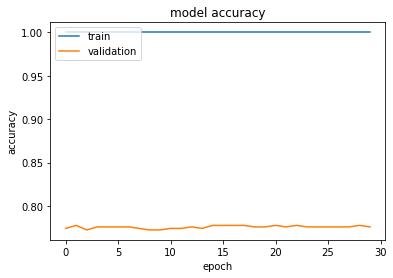

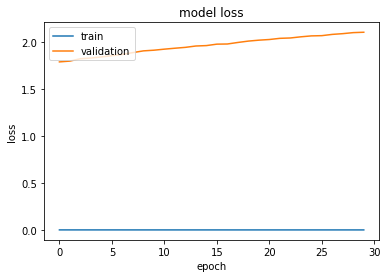

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print(max(history.history["val_accuracy"]))

0.7777777910232544
